In [45]:
!pip install pyspark

In [5]:
from pyspark.sql.functions import expr
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PolynomialExpansion

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [7]:


spark = SparkSession.builder.appName("Diamonds").getOrCreate()

In [8]:
data = spark.read.csv("diamonds.csv",
                      inferSchema = True, header = True)

data.show(5, truncate = False)

+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|_c0|carat|cut    |color|clarity|depth|table|price|x   |y   |z   |
+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|1  |0.23 |Ideal  |E    |SI2    |61.5 |55.0 |326  |3.95|3.98|2.43|
|2  |0.21 |Premium|E    |SI1    |59.8 |61.0 |326  |3.89|3.84|2.31|
|3  |0.23 |Good   |E    |VS1    |56.9 |65.0 |327  |4.05|4.07|2.31|
|4  |0.29 |Premium|I    |VS2    |62.4 |58.0 |334  |4.2 |4.23|2.63|
|5  |0.31 |Good   |J    |SI2    |63.3 |58.0 |335  |4.34|4.35|2.75|
+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 5 rows



In [9]:
data = data.select(data.columns[1:])

In [10]:
data=data.dropna()
print(data.count())

53940


In [11]:
from pyspark.sql.functions import col, isnan, when, count

# Count missing values in each column
missing_counts = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])
missing_counts.show()

+-----+---+-----+-------+-----+-----+-----+---+---+---+
|carat|cut|color|clarity|depth|table|price|  x|  y|  z|
+-----+---+-----+-------+-----+-----+-----+---+---+---+
|    0|  0|    0|      0|    0|    0|    0|  0|  0|  0|
+-----+---+-----+-------+-----+-----+-----+---+---+---+



In [12]:
# Validate 'cut' column against predefined categories
valid_cut_categories = ['Premium', 'Ideal', 'Good', 'Fair', 'Very Good']
data_filtered = data.filter(data['cut'].isin(valid_cut_categories))


In [13]:
data.printSchema()

root
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In [14]:
data.groupBy("cut").count().show()

+---------+-----+
|      cut|count|
+---------+-----+
|  Premium|13791|
|    Ideal|21551|
|     Good| 4906|
|     Fair| 1610|
|Very Good|12082|
+---------+-----+



In [15]:
data.groupBy("clarity").count().show()

+-------+-----+
|clarity|count|
+-------+-----+
|   VVS2| 5066|
|    SI1|13065|
|     IF| 1790|
|     I1|  741|
|   VVS1| 3655|
|    VS2|12258|
|    SI2| 9194|
|    VS1| 8171|
+-------+-----+



In [16]:
numeric_cols = [col for col, dtype in data.dtypes if dtype != "string"]
numeric_cols = [col for col in numeric_cols if col != "price"]

In [17]:
for col in numeric_cols:
    corr = data.corr(col, "price")
    print(f"The correlation between {col} and price is {round(corr, 2)}")


The correlation between carat and price is 0.92
The correlation between depth and price is -0.01
The correlation between table and price is 0.13
The correlation between x and price is 0.88
The correlation between y and price is 0.87
The correlation between z and price is 0.86


          carat     depth     table         x         y         z     price
carat  1.000000  0.028224  0.181618  0.975094  0.951722  0.953387  0.921591
depth  0.028224  1.000000 -0.295779 -0.025289 -0.029341  0.094924 -0.010647
table  0.181618 -0.295779  1.000000  0.195344  0.183760  0.150929  0.127134
x      0.975094 -0.025289  0.195344  1.000000  0.974701  0.970772  0.884435
y      0.951722 -0.029341  0.183760  0.974701  1.000000  0.952006  0.865421
z      0.953387  0.094924  0.150929  0.970772  0.952006  1.000000  0.861249
price  0.921591 -0.010647  0.127134  0.884435  0.865421  0.861249  1.000000


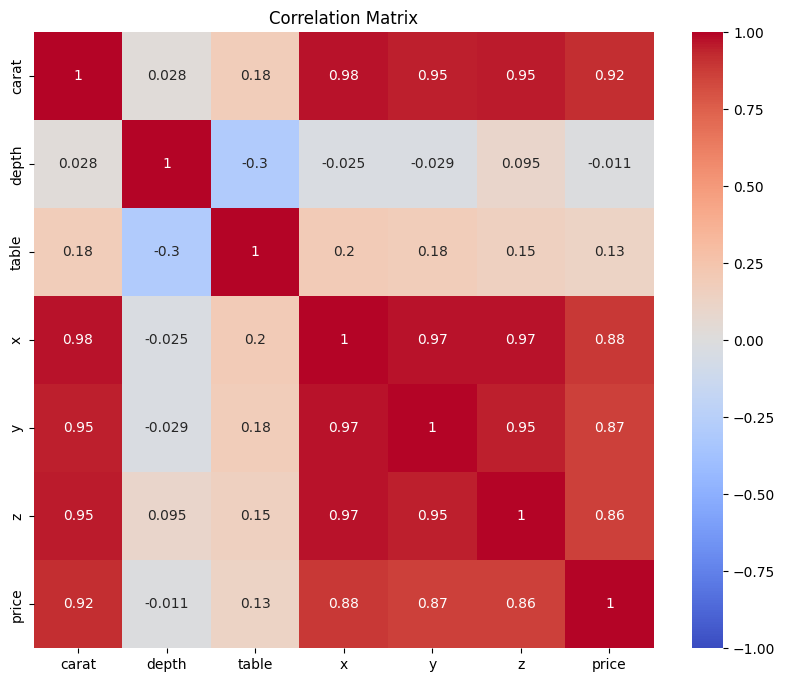

In [21]:
# Calculate correlation for each pair of numeric columns
correlations = {}
for col1 in numeric_cols:
    for col2 in numeric_cols:
        corr_value = data.corr(col1, col2)
        if col1 not in correlations:
            correlations[col1] = {}
        correlations[col1][col2] = corr_value

# Convert the correlation dictionary to a pandas DataFrame
corr_matrix = pd.DataFrame(correlations)

# Add the correlation of each numeric column with the price
price_corr = [data.corr(col, "price") for col in numeric_cols]
corr_matrix["price"] = price_corr
corr_matrix.loc["price"] = price_corr + [1.0]

# Print the correlation matrix
print(corr_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [18]:
string_cols = [col for col, dtype in data.dtypes if dtype == "string"]

for col in string_cols:
    print(f"Relationships for the column {col}")
    data.groupBy(col).agg({"price": "mean"}).show()
    print("------------------------------------------------------")


Relationships for the column cut
+---------+------------------+
|      cut|        avg(price)|
+---------+------------------+
|  Premium|4584.2577042999055|
|    Ideal| 3457.541970210199|
|     Good| 3928.864451691806|
|     Fair| 4358.757763975155|
|Very Good|3981.7598907465654|
+---------+------------------+

------------------------------------------------------
Relationships for the column color
+-----+------------------+
|color|        avg(price)|
+-----+------------------+
|    F| 3724.886396981765|
|    E|3076.7524752475247|
|    D|3169.9540959409596|
|    J|  5323.81801994302|
|    G| 3999.135671271697|
|    I| 5091.874953891553|
|    H| 4486.669195568401|
+-----+------------------+

------------------------------------------------------
Relationships for the column clarity
+-------+------------------+
|clarity|        avg(price)|
+-------+------------------+
|   VVS2| 3283.737070667193|
|    SI1| 3996.001148105626|
|     IF| 2864.839106145251|
|     I1|3924.1686909581645|
|   

In [22]:
for col in numeric_cols:
    print(f"For col {col}")
    avg_value = round(data.select(expr(f"AVG({col})")).collect()[0][0], 2)
    std_value = round(data.select(expr(f"STD({col})")).collect()[0][0], 2)
    data.select(expr(f"(ABS({col} - {avg_value}) / {std_value}) > 3").alias("z_score")).groupBy("z_score").count().show()

For col carat
+-------+-----+
|z_score|count|
+-------+-----+
|   true|  439|
|  false|53501|
+-------+-----+

For col depth
+-------+-----+
|z_score|count|
+-------+-----+
|   true|  685|
|  false|53255|
+-------+-----+

For col table
+-------+-----+
|z_score|count|
+-------+-----+
|   true|  336|
|  false|53604|
+-------+-----+

For col x
+-------+-----+
|z_score|count|
+-------+-----+
|   true|   43|
|  false|53897|
+-------+-----+

For col y
+-------+-----+
|z_score|count|
+-------+-----+
|   true|   34|
|  false|53906|
+-------+-----+

For col z
+-------+-----+
|z_score|count|
+-------+-----+
|   true|   52|
|  false|53888|
+-------+-----+



In [23]:
df = data.groupBy("cut").count().toPandas()
df

,cut,count
0,Premium,13791
1,Ideal,21551
2,Good,4906
3,Fair,1610
4,Very Good,12082


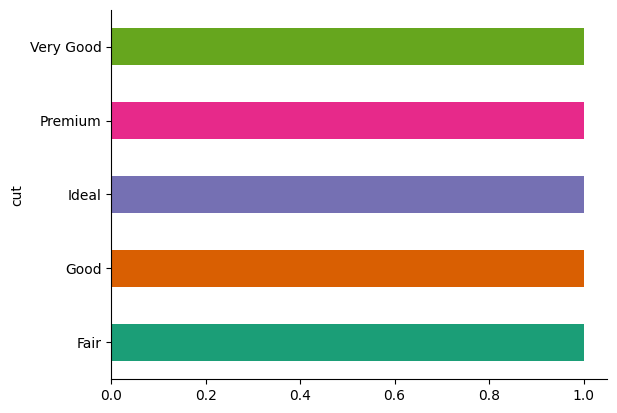

In [24]:
# @title cut

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('cut').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='cut', ylabel='count'>

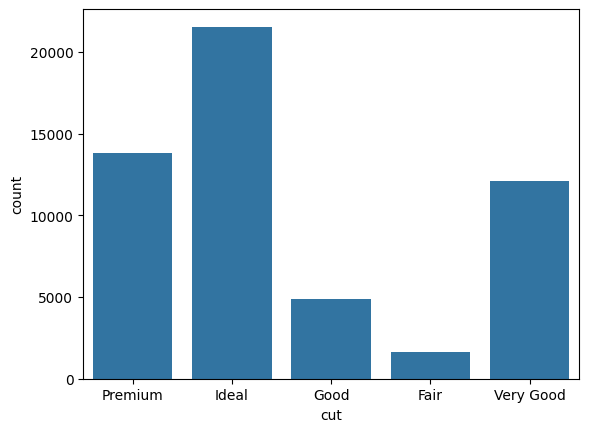

In [25]:
sns.barplot(data = df, x = "cut", y = "count")

In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

In [27]:
string_cols

['cut', 'color', 'clarity']

In [28]:
for col in string_cols:
    indexer = StringIndexer(inputCol = f"{col}", outputCol = f"{col}Index")
    encoder = OneHotEncoder(inputCol = f"{col}Index", outputCol = f"{col}Vec")
    data = indexer.fit(data).transform(data)
    data = encoder.fit(data).transform(data)

In [29]:
data.show()

+-----+---------+-----+-------+-----+-----+-----+----+----+----+--------+-------------+----------+-------------+------------+-------------+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|cutIndex|       cutVec|colorIndex|     colorVec|clarityIndex|   clarityVec|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+--------+-------------+----------+-------------+------------+-------------+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|     0.0|(4,[0],[1.0])|       1.0|(6,[1],[1.0])|         2.0|(7,[2],[1.0])|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|     1.0|(4,[1],[1.0])|       1.0|(6,[1],[1.0])|         0.0|(7,[0],[1.0])|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|     3.0|(4,[3],[1.0])|       1.0|(6,[1],[1.0])|         3.0|(7,[3],[1.0])|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|     1.0|(4,[1],[1.0])|       5.0|(6,[5],[1.0])|         1.0|(7,[1],[1.0])|
| 0.31|     Good|   

In [30]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [31]:
cols_keeps = numeric_cols + [col for col in data.columns if "vec" in col.lower()]

In [32]:
assembler = VectorAssembler(inputCols = cols_keeps,
                            outputCol = "features")

output = assembler.transform(data)

In [33]:
train, test = output.randomSplit(weights = [0.7, 0.3], seed = 42)

In [34]:
lr = LinearRegression(featuresCol = "features", labelCol = "price", predictionCol = "prediction")

model = lr.fit(train)

In [35]:
predictions = model.evaluate(test)

In [36]:
print("RMSE: {}".format(predictions.rootMeanSquaredError))
print("MSE: {}".format(predictions.meanSquaredError))
print("r2: {}".format(predictions.r2))

RMSE: 1132.113035379665
MSE: 1281679.9248765588
r2: 0.9214169256291955


In [37]:
predictions_df = predictions.predictions.select("price", "prediction").toPandas()

<Axes: xlabel='price', ylabel='prediction'>

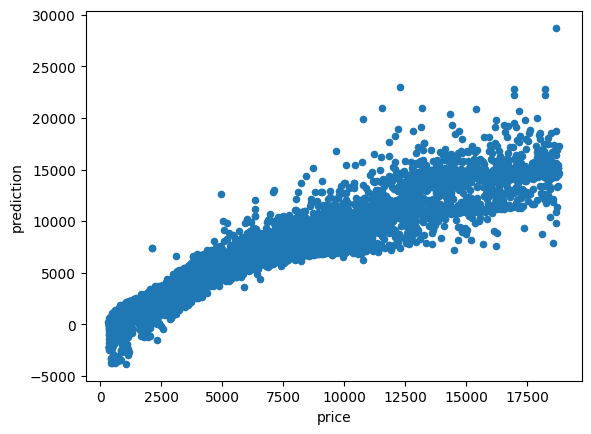

In [38]:
predictions_df.plot.scatter(x = "price", y = "prediction")

In [39]:
# Polynomial expansion
from pyspark.ml.feature import PolynomialExpansion
polyExpansion = PolynomialExpansion(degree=2, inputCol="features", outputCol="polyFeatures")
polyOutput = polyExpansion.transform(output)

In [40]:
# Split data into training and testing sets
train, test = polyOutput.randomSplit(weights=[0.7, 0.3], seed=42)

In [41]:
# Train linear regression model
lr = LinearRegression(featuresCol="polyFeatures", labelCol="price", predictionCol="prediction")
model = lr.fit(train)

In [42]:
# Evaluate the model
predictions = model.evaluate(test)
print("RMSE: {}".format(predictions.rootMeanSquaredError))
print("MSE: {}".format(predictions.meanSquaredError))
print("r2: {}".format(predictions.r2))

RMSE: 972.3562635494721
MSE: 945476.7032638905
r2: 0.9420304050595119


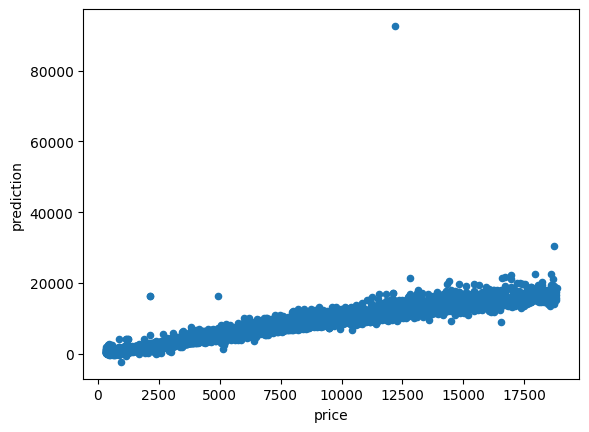

In [43]:
# Plot predictions vs actual prices
predictions_df = predictions.predictions.select("price", "prediction").toPandas()
predictions_df.plot.scatter(x="price", y="prediction")
plt.show()

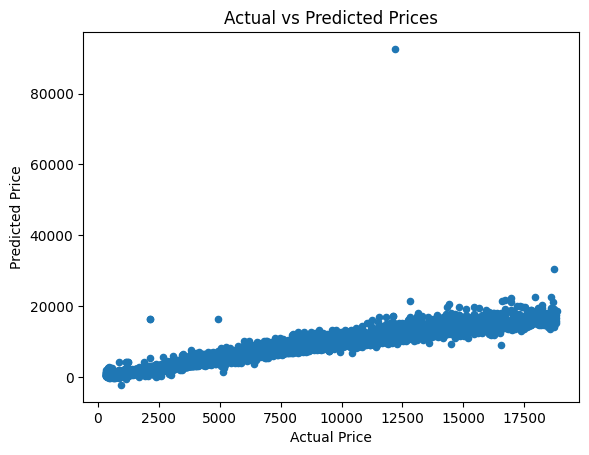

In [44]:
# Plot predictions vs actual prices
predictions_df = predictions.predictions.select("price", "prediction").toPandas()
predictions_df.plot.scatter(x="price", y="prediction")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()